In [1]:
%pylab inline
import os
import caffe

Populating the interactive namespace from numpy and matplotlib


In [2]:
netd = os.path.expanduser('~/Documents/nets/deepsim/fc8/generator_no_batch.prototxt')
netw = os.path.expanduser('~/Documents/nets/deepsim/fc8/generator.caffemodel')
net = caffe.Net(netd, caffe.TEST, weights=netw)

In [3]:
print('caffe layers and parameters')
for k, v in net.params.items():
    print(k, f'{str(v[0].data.shape):>20}', f'{str(v[1].data.shape):>8}',
          'bias mean', f'{np.abs(v[1].data).mean():.3f}', sep='\t')

caffe layers and parameters
defc7	        (4096, 1000)	 (4096,)	bias mean	0.529
defc6	        (4096, 4096)	 (4096,)	bias mean	0.608
defc5	        (4096, 4096)	 (4096,)	bias mean	0.360
deconv5	    (256, 256, 4, 4)	  (256,)	bias mean	0.000
conv5_1	    (256, 512, 3, 3)	  (512,)	bias mean	0.000
deconv4	    (512, 256, 4, 4)	  (256,)	bias mean	0.000
conv4_1	    (256, 256, 3, 3)	  (256,)	bias mean	0.000
deconv3	    (256, 128, 4, 4)	  (128,)	bias mean	0.000
conv3_1	    (128, 128, 3, 3)	  (128,)	bias mean	0.000
deconv2	     (128, 64, 4, 4)	   (64,)	bias mean	0.000
deconv1	      (64, 32, 4, 4)	   (32,)	bias mean	0.000
deconv0	       (32, 3, 4, 4)	    (3,)	bias mean	0.000


In [4]:
import torch
from torch import nn

class DeePSiMFc8(nn.Module):
    def __init__(self):
        super().__init__()
        # reusable activation funcs
        self.lrelu = nn.LeakyReLU(negative_slope=0.3)
        
        # layers
        self.fc7 = nn.Linear(1000, 4096)
        self.fc6 = nn.Linear(4096, 4096)
        self.fc5 = nn.Linear(4096, 4096)
        self.tconv5_0 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1, bias=False)
        self.tconv5_1 = nn.ConvTranspose2d(256, 512, 3, stride=1, padding=1, bias=False)
        self.tconv4_0 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)
        self.tconv4_1 = nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1, bias=False)
        self.tconv3_0 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.tconv3_1 = nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1, bias=False)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
        self.tconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False)
        self.tconv0 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1, bias=False)
        
    def forward(self, x):
        lrelu = self.lrelu
        x = lrelu(self.fc7(x))
        x = lrelu(self.fc6(x))
        x = lrelu(self.fc5(x))
        x = x.view(-1, 256, 4, 4)
        x = lrelu(self.tconv5_0(x))
        x = lrelu(self.tconv5_1(x))
        x = lrelu(self.tconv4_0(x))
        x = lrelu(self.tconv4_1(x))
        x = lrelu(self.tconv3_0(x))
        x = lrelu(self.tconv3_1(x))
        x = lrelu(self.tconv2(x))
        x = lrelu(self.tconv1(x))
        x = self.tconv0(x)
        return x

In [5]:
torch_net = DeePSiMFc8()
for n, p in torch_net.named_parameters():
    print(f'{n:<20}', f'{str(tuple(p.shape)):>20}', sep='\t')

fc7.weight          	        (4096, 1000)
fc7.bias            	             (4096,)
fc6.weight          	        (4096, 4096)
fc6.bias            	             (4096,)
fc5.weight          	        (4096, 4096)
fc5.bias            	             (4096,)
tconv5_0.weight     	    (256, 256, 4, 4)
tconv5_1.weight     	    (256, 512, 3, 3)
tconv4_0.weight     	    (512, 256, 4, 4)
tconv4_1.weight     	    (256, 256, 3, 3)
tconv3_0.weight     	    (256, 128, 4, 4)
tconv3_1.weight     	    (128, 128, 3, 3)
tconv2.weight       	     (128, 64, 4, 4)
tconv1.weight       	      (64, 32, 4, 4)
tconv0.weight       	       (32, 3, 4, 4)


In [6]:
tshapes = [tuple(p.shape) for p in torch_net.parameters()]

cshapes = []
for k, v in net.params.items():
    cshapes.append(v[0].data.shape)
    if 'conv' not in k:
        cshapes.append(v[1].data.shape)
len(cshapes), sorted(cshapes)

print('collection of torch and caffe param shapes agree?')
print(tuple(sorted(tshapes)) == tuple(sorted(cshapes)))

collection of torch and caffe param shapes agree?
True


In [7]:
def transfer_params(caffe_net, torch_net, verbose=True):
    if verbose:
        print('caffe parameter name : torch parameter name')
    for n, p in torch_net.named_parameters():
        n1, n2 = n.split('.')
        wb_idx = 1 if n2 == 'bias' else 0
        if n1[-2:] == '_1':
            caffe_n = n1.replace('tconv', 'conv')
        elif n1.find('tconv') == 0:
            if n1[-2] == '_':
                n1 = n1[:-2]
            caffe_n = n1.replace('tconv', 'deconv')
        else:
            caffe_n = n1.replace('fc', 'defc')
        if verbose:
            print(f"{caffe_n+'.'+('weight', 'bias')[wb_idx]:<20}", ':', f'{n:<20}', sep='\t')
        p.data = torch.Tensor(caffe_net.params[caffe_n][wb_idx].data)

In [8]:
transfer_params(net, torch_net)

caffe parameter name : torch parameter name
defc7.weight        	:	fc7.weight          
defc7.bias          	:	fc7.bias            
defc6.weight        	:	fc6.weight          
defc6.bias          	:	fc6.bias            
defc5.weight        	:	fc5.weight          
defc5.bias          	:	fc5.bias            
deconv5.weight      	:	tconv5_0.weight     
conv5_1.weight      	:	tconv5_1.weight     
deconv4.weight      	:	tconv4_0.weight     
conv4_1.weight      	:	tconv4_1.weight     
deconv3.weight      	:	tconv3_0.weight     
conv3_1.weight      	:	tconv3_1.weight     
deconv2.weight      	:	tconv2.weight       
deconv1.weight      	:	tconv1.weight       
deconv0.weight      	:	tconv0.weight       


In [9]:
torch_net.to(device='cuda');

In [10]:
code = np.random.normal(0, 0.1, size=(1,1000)).astype(np.float32)

In [16]:
tim = torch_net.forward(torch.tensor(code, device='cuda'))
tim = tim.detach().cpu().numpy()

cim = net.forward(feat=code)['generated']

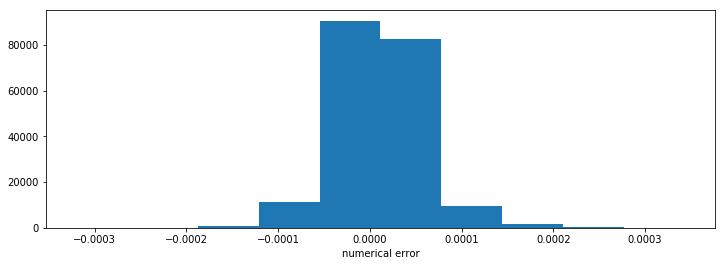

In [17]:
figure(figsize=(12,4))
hist((tim-cim).flatten(), density=False)
xlabel('numerical error');

In [18]:
inet_mean = np.array((104.0, 117.0, 123.0))    # BGR

def deprocess(im):
    im = np.rollaxis(im, -3, len(im.shape))
    im += inet_mean
    im = im[..., ::-1]
    return np.clip(im, 0, 255).astype(np.uint8)

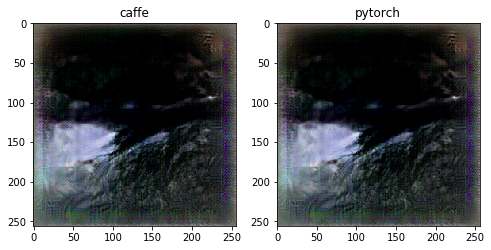

In [19]:
fig, axs = subplots(1, 2, figsize=(8,4))
axs[0].imshow(deprocess(cim)[0])
axs[0].set_title('caffe')
axs[1].imshow(deprocess(tim)[0])
axs[1].set_title('pytorch');

In [20]:
torch.save(torch_net.state_dict(), os.path.expanduser('~/Documents/nets/pytorch/deepsim/fc8.pt'))